In [1]:
import os
import re
import pandas as pd
import numpy as np
import duckdb
import unicodedata
from tqdm import tqdm
from textblob import TextBlob
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
# from xgboost import XGBClassifier
from scipy.stats import trim_mean
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from langdetect import detect, LangDetectException
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from scipy.stats import trim_mean

In [2]:
def preprocess_runtime(df, k=0.1):
    """
    Preprocesses the runtime information, including handling extreme values
    (movies with runtime > 1000 minutes, possibly in seconds or hours).

    Arguments:
    - df: DataFrame containing the movie data.
    - k: Proportion of values to trim from each end when computing the trimmed mean.

    Returns:
    - DataFrame with cleaned runtime information.
    """
    # First convert to numeric, coercing errors to NaN
    df["runtimeMinutes"] = pd.to_numeric(df["runtimeMinutes"], errors='coerce')

    # Compute k-trimmed mean for runtimeMinutes (ignoring NaN values)
    trimmed_mean_runtime = trim_mean(df["runtimeMinutes"].dropna().values, proportiontocut=k)

    # Fill missing values with trimmed mean
    df["runtimeMinutes"] = df["runtimeMinutes"].fillna(trimmed_mean_runtime)

    # Handle movies that are possibly in seconds or hours
    df["runtimeMinutes"] = df["runtimeMinutes"].apply(lambda x: x / 60 if pd.notna(x) and x > 1000 else x)  # Convert seconds to minutes
    df["runtimeMinutes"] = df["runtimeMinutes"].apply(lambda x: x * 60 if pd.notna(x) and x < 5 else x)  # Convert minutes to hours if under 5 mins

    # Now convert to int (after handling extreme values and filling NaNs)
    df["runtimeMinutes"] = df["runtimeMinutes"].round().astype(int)

    return df

In [3]:
def load_and_merge_imdb_data(data_path, directors_path, writers_path, creative_encoder=None, fit=False):
    """
    Step 1: Load, merge, and perform initial cleaning of IMDB data.
    """
    df = pd.read_csv(data_path)

    # Step 2: Load JSON files (Directors & Writers)
    df_directors = pd.read_json(directors_path)
    df_writers = pd.read_json(writers_path)

    # Step 3: Rename columns for consistency
    df_directors.rename(columns={"movie": "tconst", "director": "director_id"}, inplace=True)
    df_writers.rename(columns={"movie": "tconst", "writer": "writer_id"}, inplace=True)

    # Step 4: Convert nested JSON fields into strings
    df_directors["director_id"] = df_directors["director_id"].astype(str)
    df_writers["writer_id"] = df_writers["writer_id"].astype(str)

    # Step 5: Label Encoding for Directors and Writers
    # Create a unified set of all creative professionals
    all_creatives = set(df_directors["director_id"]).union(set(df_writers["writer_id"]))

    # Add unknown value
    all_creatives.add("unknown")

    # Create or use encoder
    if creative_encoder is None and fit:
        creative_encoder = LabelEncoder()
        creative_encoder.fit(list(all_creatives))

    # Handle encoding
    if creative_encoder is not None:
        # Handle unknown values for directors
        df_directors["director_id"] = df_directors["director_id"].apply(
            lambda x: x if x in creative_encoder.classes_ else "unknown")
        df_directors["director_id"] = creative_encoder.transform(df_directors["director_id"])

        # Handle unknown values for writers
        df_writers["writer_id"] = df_writers["writer_id"].apply(
            lambda x: x if x in creative_encoder.classes_ else "unknown")
        df_writers["writer_id"] = creative_encoder.transform(df_writers["writer_id"])


    # Step 6: Merge main dataset with Directors & Writers using DuckDB
    con = duckdb.connect()
    con.register("movies", df)
    con.register("directors", df_directors)
    con.register("writers", df_writers)

    query = """
    SELECT
        movies.*,
        directors.director_id,
        writers.writer_id
    FROM movies
    LEFT JOIN directors ON movies.tconst = directors.tconst
    LEFT JOIN writers ON movies.tconst = writers.tconst
    """
    df = con.execute(query).fetchdf()
    con.close()

    # Fill missing values
    df["director_id"] = df["director_id"].fillna(creative_encoder.transform(["unknown"])[0])
    df["writer_id"] = df["writer_id"].fillna(creative_encoder.transform(["unknown"])[0])

    if fit:
        return df, creative_encoder
    else:
        return df


In [4]:
def merge_imdb_rotten(imdb_data, rotten_data):
    """
    Merges IMDb and Rotten Tomatoes data on movie titles.

    Parameters:
    - imdb_data (pd.DataFrame): Cleaned IMDb dataset.
    - rotten_data (pd.DataFrame): Cleaned Rotten Tomatoes dataset.

    Returns:
    - pd.DataFrame: Merged DataFrame with both IMDb and Rotten Tomatoes data.
    """

    # Create an explicit copy to avoid SettingWithCopyWarning
    df_ratings = rotten_data[[
        "movie_title", "tomatometer_rating", "audience_rating"
    ]].copy()

    # Convert columns to numeric safely
    df_ratings.loc[:, "tomatometer_rating"] = pd.to_numeric(df_ratings["tomatometer_rating"], errors="coerce")
    df_ratings.loc[:, "audience_rating"] = pd.to_numeric(df_ratings["audience_rating"], errors="coerce")

    # Calculate the median values
    median_tomatometer = df_ratings['tomatometer_rating'].median()
    median_audience = df_ratings['audience_rating'].median()

    # Fill NaNs with median values before merging
    df_ratings["tomatometer_rating"] = df_ratings["tomatometer_rating"].fillna(median_tomatometer)
    df_ratings["audience_rating"] = df_ratings["audience_rating"].fillna(median_audience)

    # Normalize movie titles
    def normalize_text(text):
        if pd.isna(text):  # Handle missing values
            return ""
        text = str(text)
        text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')  # Remove accents
        text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
        return text.strip()

    df_ratings["movieTitle"] = df_ratings["movie_title"].apply(normalize_text)
    df_ratings = df_ratings.drop(columns=["movie_title"])

    # Convert movie titles to strings for consistency
    imdb_data['movieTitle'] = imdb_data['movieTitle'].astype(str)
    df_ratings['movieTitle'] = df_ratings['movieTitle'].astype(str)

    # Merge IMDb and Rotten Tomatoes data using DuckDB
    con = duckdb.connect()
    con.register("imdb_data", imdb_data)
    con.register("rotten_data", df_ratings)

    query = """
        SELECT 
            imdb_data.*, 
            rotten_data.tomatometer_rating, 
            rotten_data.audience_rating
        FROM imdb_data
        LEFT JOIN rotten_data 
        ON imdb_data.movieTitle = rotten_data.movieTitle
    """

    merged_df = con.execute(query).fetchdf()
    con.close()

    # Fill NaNs with median values again after merging
    merged_df["tomatometer_rating"] = merged_df["tomatometer_rating"].fillna(median_tomatometer)
    merged_df["audience_rating"] = merged_df["audience_rating"].fillna(median_audience)

    return merged_df


In [5]:
def preprocess_imdb_data(df, language_encoder=None, fit=False):
    """
    General preprocessing pipeline for IMDB data.
    
    Arguments:
    - data_path: Path to the train/test/validation data CSV file.
    - directors_path: Path to the directing.json file.
    - writers_path: Path to the writing.json file.
    
    Returns:
    - Cleaned Pandas DataFrame ready for model training or prediction.
    """

    # Step 7: Create column year from startYear and endYear
    df['startYear'] = df['startYear'].replace('\\N', np.nan).astype(float)
    df['endYear'] = df['endYear'].replace('\\N', np.nan).astype(float)
    df['Year'] = df['startYear'].fillna(df['endYear'])

    # Step 8: Add language detection
    def detect_language(row):
        try:
            # Try to detect language from originalTitle first
            if pd.notna(row['originalTitle']) and row['originalTitle'].strip():
                return detect(row['originalTitle'])
            # If originalTitle is missing, try primaryTitle
            elif pd.notna(row['primaryTitle']) and row['primaryTitle'].strip():
                language = detect(row['primaryTitle'])
                # If primaryTitle is detected as English, return 'en'
                return language
            else:
                return 'unknown'
        except LangDetectException:
            return 'unknown'

    # Add language column before dropping originalTitle
    df['title_language'] = df.apply(detect_language, axis=1)

    # Step 9: Handle the language feature more robustly
    df['title_language'] = df['title_language'].fillna('unknown')
    
    # Create a new encoder if one wasn't provided
    if language_encoder is None:
        language_encoder = LabelEncoder()

    # Fit the encoder on training data if fit=True, otherwise use as-is
    if fit:
        df['title_language'] = language_encoder.fit_transform(df['title_language'])
    else:
        # Handle unseen values in test/val sets
        unique_langs = set(df['title_language'])
        known_langs = set(language_encoder.classes_)
        unknown_langs = unique_langs - known_langs

        if unknown_langs:
            print(f"Warning: Found {len(unknown_langs)} unknown languages in data")
            # Replace unknown languages with 'unknown' before transform
            df['title_language'] = df['title_language'].apply(
                lambda x: 'unknown' if x in unknown_langs else x
            )

        df['title_language'] = language_encoder.transform(df['title_language'])

    # Step 10: Clean title names
    def normalize_text(text):
        if pd.isna(text):  # Handle missing values
            return ""
        text = str(text)
        text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')  # Remove accents
        text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
        return text.strip()

    def clean_titles(row):
        primary = row['primaryTitle'] if pd.notna(row['primaryTitle']) else ''
        original = row['originalTitle'] if pd.notna(row['originalTitle']) else ''

        if not primary:
            primary = original

        cleaned_title = normalize_text(primary)

        return cleaned_title if cleaned_title else "Unknown Title"

    df['primaryTitle'] = df.apply(clean_titles, axis=1)
    df = df.rename(columns={'primaryTitle': 'movieTitle'})

    # Step 11: Compute Sentiment Score
    df["sentiment_score"] = df["movieTitle"].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

    # Step 12: Count words in each title
    df["word_count"] = df["movieTitle"].apply(lambda x: len(x.split()))

    # Step 13: Handle missing values for runtime
    df = preprocess_runtime(df, 0.1)

    # Step 14: Fill missing values for numVotes
    trimmed_mean_votes = trim_mean(df["numVotes"].dropna(), proportiontocut=0.1)
    df["numVotes"] = df["numVotes"].fillna(trimmed_mean_votes)

    # Step 15: Fill missing values for director_id and writer_id
    df["director_id"] = df["director_id"].fillna("unknown")
    df["writer_id"] = df["writer_id"].fillna("unknown")

    # Step 16: Ensure correct data types
    df["Year"] = df["Year"].astype(int)
    df["numVotes"] = df["numVotes"].astype(int)

    # Step 17: Merge Rotten tomatoes dataset
    rotten_data = pd.read_csv('RottenTomatoes/rotten_tomatoes_movies.csv')
    final_df = merge_imdb_rotten(df, rotten_data)

    # Step 18: Ensure each `tconst` is unique
    final_df = final_df.groupby("tconst").first().reset_index()

    # Step 19: Drop unnecessary columns
    columns_to_drop = ["originalTitle", "endYear", "startYear", "Unnamed: 0", "tconst", "movieTitle"]
    final_df = final_df.drop(columns=[col for col in columns_to_drop if col in df.columns])

    
    if fit:
        return final_df, language_encoder
    else:
        return final_df


In [6]:
# Define file paths
# Define the base directory
base_data_dir = os.path.join(os.getcwd(), "imdb")

# Generate the list of train file paths
train_files = [os.path.join(base_data_dir, f) for f in os.listdir(base_data_dir) if f.startswith("train-") and f.endswith(".csv")]

# Define paths for directors and writers files
directors_path = os.path.join(base_data_dir, "directing.json")
writers_path = os.path.join(base_data_dir, "writing.json")

# Load JSON files (Directors & Writers)
df_directors = pd.read_json(directors_path)
df_writers = pd.read_json(writers_path)

# Step 1: Load and merge raw data
first_df, creative_encoder = load_and_merge_imdb_data(train_files[0], directors_path, writers_path, fit=True)

# Then process remaining files with the encoder
all_dfs = [first_df]  # Start with the first DataFrame
for file in train_files[1:]:
    df = load_and_merge_imdb_data(file, directors_path, writers_path,
                                 creative_encoder=creative_encoder, fit=False)
    all_dfs.append(df)

# Concatenate all DataFrames
df_intermediate = pd.concat(all_dfs)

# Step 2: Process features and finalize dataset
df_train, language_encoder = preprocess_imdb_data(df_intermediate, fit=True)

# Preprocess validation and test data
df_intermediate_val = load_and_merge_imdb_data(os.path.join(base_data_dir, "validation_hidden.csv"), directors_path, writers_path, creative_encoder=creative_encoder)
df_val = preprocess_imdb_data(df_intermediate_val, language_encoder, fit=False)
df_intermediate_test= load_and_merge_imdb_data(os.path.join(base_data_dir, "test_hidden.csv"), directors_path, writers_path, creative_encoder=creative_encoder)
df_test = preprocess_imdb_data(df_intermediate_test, language_encoder, fit=False)

# Save cleaned datasets
df_train.to_csv("cleaned/final_training_data_ratings.csv", index=False)
df_val.to_csv("cleaned/final_validation_data_ratings.csv", index=False)
df_test.to_csv("cleaned/final_test_data_ratings.csv", index=False)

print("\n✅ All datasets have been preprocessed and saved!")


✅ All datasets have been preprocessed and saved!


In [7]:
print("NaN values at the end", df_train.isna().sum())
print("NaN values at the end", df_val.isna().sum())
print("NaN values at the end", df_test.isna().sum())

NaN values at the end runtimeMinutes        0
numVotes              0
label                 0
director_id           0
writer_id             0
Year                  0
title_language        0
sentiment_score       0
word_count            0
tomatometer_rating    0
audience_rating       0
dtype: int64
NaN values at the end runtimeMinutes        0
numVotes              0
director_id           0
writer_id             0
Year                  0
title_language        0
sentiment_score       0
word_count            0
tomatometer_rating    0
audience_rating       0
dtype: int64
NaN values at the end runtimeMinutes        0
numVotes              0
director_id           0
writer_id             0
Year                  0
title_language        0
sentiment_score       0
word_count            0
tomatometer_rating    0
audience_rating       0
dtype: int64


In [8]:
def calculate_unique_ratio(df, columns=None):
    """
    Calculate the ratio of unique rows to total rows in the DataFrame.

    Arguments:
    - df: DataFrame to analyze
    - columns: List of columns to consider (if None, uses all columns)

    Returns:
    - Dictionary containing unique ratio metrics
    """
    if columns is None:
        columns = df.columns

    total_rows = len(df)
    unique_rows = len(df[columns].drop_duplicates())
    ratio = unique_rows / total_rows

    metrics = {
        "total_rows": total_rows,
        "unique_rows": unique_rows,
        "unique_ratio": ratio
    }

    return metrics

# Add this after your data preprocessing
print("\n🔍 Analyzing unique row ratios...")

# Calculate ratios for all datasets
train_metrics = calculate_unique_ratio(df_train)
val_metrics = calculate_unique_ratio(df_val)
test_metrics = calculate_unique_ratio(df_test)

# Print results
print("\nUnique Row Analysis:")
print(f"Training Data:")
print(f"  - Total Rows: {train_metrics['total_rows']:,}")
print(f"  - Unique Rows: {train_metrics['unique_rows']:,}")
print(f"  - Unique Ratio: {train_metrics['unique_ratio']:.2%}")

print(f"\nValidation Data:")
print(f"  - Total Rows: {val_metrics['total_rows']:,}")
print(f"  - Unique Rows: {val_metrics['unique_rows']:,}")
print(f"  - Unique Ratio: {val_metrics['unique_ratio']:.2%}")

print(f"\nTest Data:")
print(f"  - Total Rows: {test_metrics['total_rows']:,}")
print(f"  - Unique Rows: {test_metrics['unique_rows']:,}")
print(f"  - Unique Ratio: {test_metrics['unique_ratio']:.2%}")


🔍 Analyzing unique row ratios...

Unique Row Analysis:
Training Data:
  - Total Rows: 7,959
  - Unique Rows: 7,959
  - Unique Ratio: 100.00%

Validation Data:
  - Total Rows: 955
  - Unique Rows: 955
  - Unique Ratio: 100.00%

Test Data:
  - Total Rows: 1,086
  - Unique Rows: 1,086
  - Unique Ratio: 100.00%


In [9]:
def handle_duplicates(df, groupby_cols=None, agg_strategy=None):
    """
    Handle duplicate rows using specified aggregation strategies.

    Arguments:
    - df: DataFrame to process
    - groupby_cols: List of columns to identify duplicates (default: all columns except label)
    - agg_strategy: Dictionary of column names and aggregation functions

    Returns:
    - DataFrame with handled duplicates
    """
    if groupby_cols is None:
        groupby_cols = [col for col in df.columns if col != 'label']

    if agg_strategy is None:
        agg_strategy = {
            'runtimeMinutes': 'mean',
            'numVotes': 'sum',
            'startYear': 'first',
            'director_id': 'first',
            'writer_id': 'first',
            'label': 'mode'
        }

    # Count occurrences before deduplication
    total_rows = len(df)
    unique_rows = len(df[groupby_cols].drop_duplicates())

    if total_rows == unique_rows:
        print("No duplicates found!")
        return df

    print(f"\nFound {total_rows - unique_rows:,} duplicate rows")
    print(f"Unique ratio before: {(unique_rows/total_rows):.2%}")

    # Handle duplicates using aggregation
    df_cleaned = df.groupby(groupby_cols, as_index=False).agg(agg_strategy)

    # Print results
    print(f"Rows after duplicate handling: {len(df_cleaned):,}")
    print(f"Unique ratio after: {(len(df_cleaned)/total_rows):.2%}")

    return df_cleaned

# Handle duplicates
print("\n🔍 Handling duplicates...")
df_train = handle_duplicates(df_train)
df_val = handle_duplicates(df_val)
df_test = handle_duplicates(df_test)


🔍 Handling duplicates...
No duplicates found!
No duplicates found!
No duplicates found!


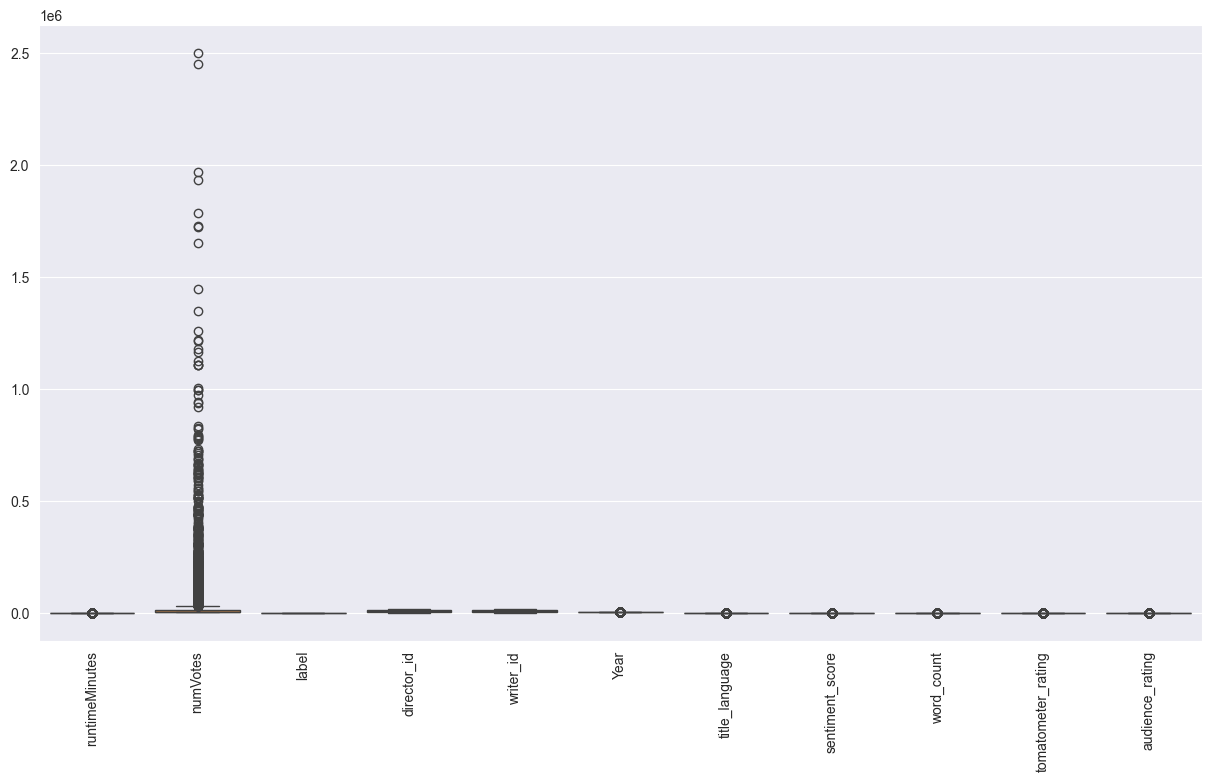

In [10]:
# Load preprocessed training dataset
df_train = pd.read_csv("cleaned/final_training_data_ratings.csv")

# Boxplots to check for outliers
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_train)
plt.xticks(rotation=90)
plt.show()

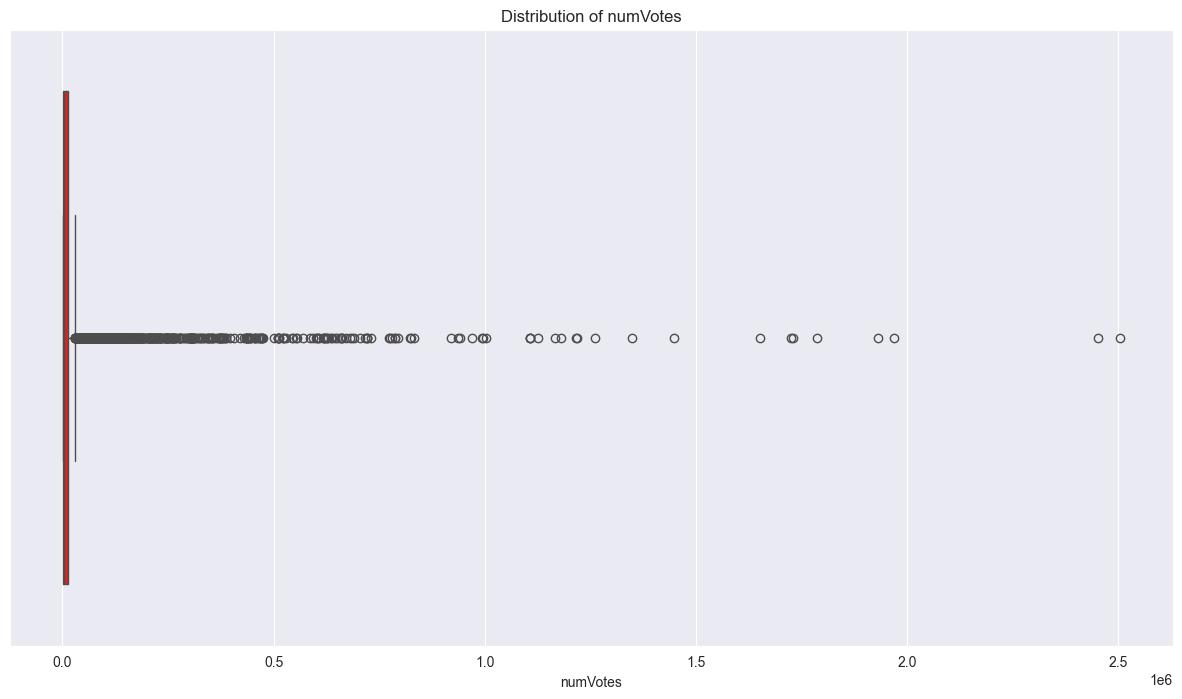

In [11]:
# Load preprocessed training dataset
df_train = pd.read_csv("cleaned/final_training_data_ratings.csv")

# Boxplots to check for outliers
plt.figure(figsize=(15, 8))
sns.boxplot(x='numVotes', data=df_train, color='red')
plt.title('Distribution of numVotes')
plt.show()

Label distribution:
label
True     3990
False    3969
Name: count, dtype: int64
Percentage of positive labels: 50.13%
Percentage of negative labels: 49.87%


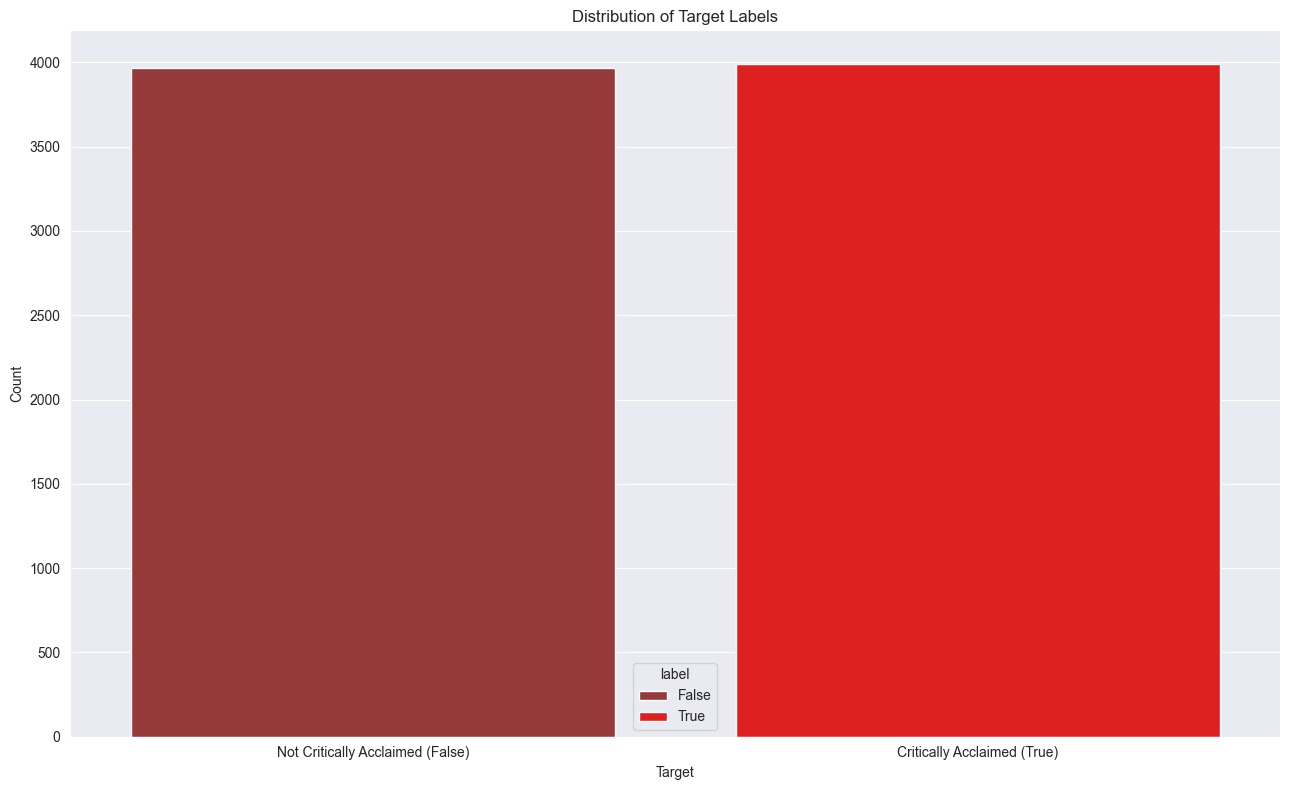

✅ Dataset is roughly balanced


In [12]:
# Check the distribution of labels
label_counts = df_train['label'].value_counts()
print(f"Label distribution:\n{label_counts}")
print(f"Percentage of positive labels: {label_counts[True]/len(df_train)*100:.2f}%")
print(f"Percentage of negative labels: {label_counts[False]/len(df_train)*100:.2f}%")

# Create a bar plot to visualize the distribution
plt.figure(figsize=(13, 8))
sns.countplot(x='label', data=df_train, hue='label', palette=['brown', 'red'])
plt.title('Distribution of Target Labels')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Critically Acclaimed (False)', 'Critically Acclaimed (True)'])
plt.tight_layout()
plt.show()

# Check if dataset is balanced
if abs(label_counts[False] - label_counts[True])/len(df_train) < 0.1:
    print("✅ Dataset is roughly balanced")
else:
    print("⚠️ Dataset is imbalanced - consider using class weights or resampling techniques")

In [13]:
# Load preprocessed training dataset
df_train = pd.read_csv("cleaned/final_training_data_ratings.csv")

df_train.head()

,runtimeMinutes,numVotes,label,director_id,writer_id,Year,title_language,sentiment_score,word_count,tomatometer_rating,audience_rating
0,93,1119,False,5142,4512,1918,22,0.000000,1,67.0,63.0
1,66,1898,True,6247,10386,1919,5,0.000000,2,67.0,63.0
2,79,2439,True,7279,12590,1920,6,0.000000,4,91.0,79.0
3,94,1264,True,529,5045,1920,9,0.000000,3,67.0,63.0
4,145,5376,True,96,96,1920,6,-0.155556,3,95.0,69.0


In [14]:
# Load preprocessed training dataset
df_train = pd.read_csv("cleaned/final_training_data_ratings.csv")
X = df_train.drop(columns = ["label"])
y = df_train["label"]  # Only train data has labels

# Split training data into train (80%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing Pipeline for all features
all_features = X_train.columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), all_features),  # Apply StandardScaler to all columns
    ],
    remainder='passthrough'  # Keep any non-numeric columns as they are
)

# Create base pipeline with preprocessing
pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", None)  # Placeholder for classifier
])


classifiers = {
    "LogisticRegression": {
        "classifier": [LogisticRegression(max_iter=1000, random_state=42)],
        "classifier__C": [0.1, 1.0, 10.0],
        "classifier__solver": ["liblinear", "lbfgs"]
    },
    "SVC": {
        "classifier": [SVC(probability=True, random_state=42)],
        "classifier__C": [0.1, 1.0, 10.0],
        "classifier__kernel": ["linear", "rbf"]
    },
    "RandomForest": {
        "classifier": [RandomForestClassifier(random_state=42)],
        "classifier__n_estimators": [100, 200],
        "classifier__max_depth": [None, 20]
    },
    "GradientBoosting": {
        "classifier": [GradientBoostingClassifier(random_state=42)],
        "classifier__n_estimators": [100, 200],
        "classifier__learning_rate": [0.01, 0.1]
    },
    "AdaBoost": {
        "classifier": [AdaBoostClassifier(random_state=42)],
        "classifier__n_estimators": [50, 100, 200],
        "classifier__learning_rate": [0.01, 0.1, 1.0]
    }
}

# Perform GridSearch for each classifier
results = {}
print("🔍 Starting grid search across classifiers...")

for name, param_grid in classifiers.items():
    print(f"\nEvaluating {name}...")
    start_time = time.time()

    grid = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring="accuracy",
        n_jobs=-1
    )

    # Train model
    grid.fit(X_train, y_train)

    # Get best model
    best_model = grid.best_estimator_

    # Evaluate on validation set
    y_val_pred = best_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    # Store results
    results[name] = {
        "best_model": best_model,
        "best_params": grid.best_params_,
        "best_cv_score": grid.best_score_,
        "val_accuracy": val_accuracy,
        "time": time.time() - start_time
    }

    print(f"✅ Best parameters: {grid.best_params_}")
    print(f"✅ Cross-validation accuracy: {grid.best_score_:.4f}")
    print(f"✅ Validation accuracy: {val_accuracy:.4f}")
    print(f"⏱️ Time: {results[name]['time']:.2f} seconds")

# Print summary table sorted by validation accuracy
print("\n📊 Summary of Results (sorted by validation accuracy):")
print(f"{'Classifier':<20} {'Val Accuracy':<15} {'CV Accuracy':<15} {'Time (s)':<10}")
print("-" * 60)

for name, result in sorted(results.items(), key=lambda x: x[1]["val_accuracy"], reverse=True):
    print(f"{name:<20} {result['val_accuracy']:.4f}{' '*10} {result['best_cv_score']:.4f}{' '*10} {result['time']:.2f}")

# Get best model
best_classifier = max(results.items(), key=lambda x: x[1]["val_accuracy"])
best_name = best_classifier[0]
best_result = best_classifier[1]
best_model = best_result["best_model"]

print(f"\n🏆 Best classifier: {best_name}")
print(f"✅ Validation accuracy: {best_result['val_accuracy']:.4f}")

# Detailed evaluation of best model
y_val_pred = best_result["best_model"].predict(X_val)
print(f"\n📊 Classification Report for {best_name}:\n")
print(classification_report(y_val, y_val_pred))

🔍 Starting grid search across classifiers...

Evaluating LogisticRegression...
✅ Best parameters: {'classifier': LogisticRegression(max_iter=1000, random_state=42), 'classifier__C': 0.1, 'classifier__solver': 'liblinear'}
✅ Cross-validation accuracy: 0.7776
✅ Validation accuracy: 0.7726
⏱️ Time: 0.96 seconds

Evaluating SVC...
✅ Best parameters: {'classifier': SVC(probability=True, random_state=42), 'classifier__C': 10.0, 'classifier__kernel': 'rbf'}
✅ Cross-validation accuracy: 0.7877
✅ Validation accuracy: 0.7915
⏱️ Time: 10.25 seconds

Evaluating RandomForest...
✅ Best parameters: {'classifier': RandomForestClassifier(random_state=42), 'classifier__max_depth': None, 'classifier__n_estimators': 200}
✅ Cross-validation accuracy: 0.8046
✅ Validation accuracy: 0.8109
⏱️ Time: 4.14 seconds

Evaluating GradientBoosting...
✅ Best parameters: {'classifier': GradientBoostingClassifier(random_state=42), 'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200}
✅ Cross-validation accu

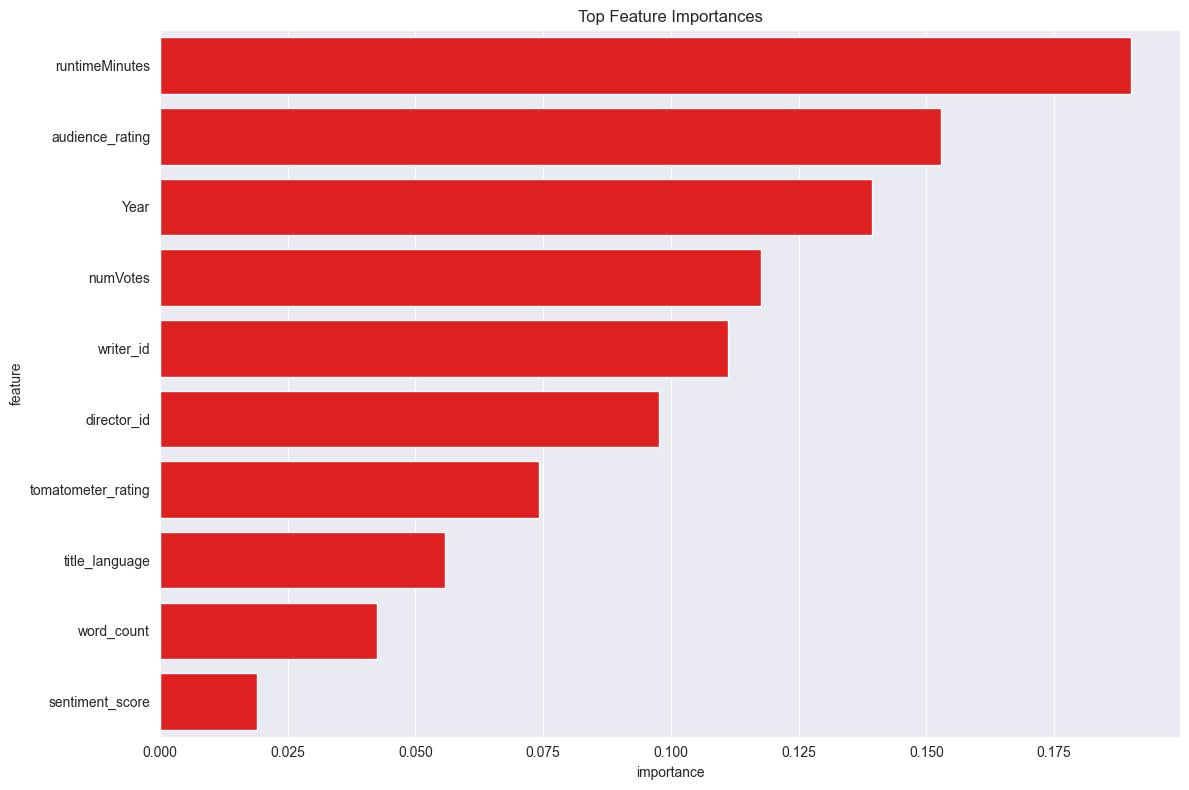


Top 10 most important features:
              feature  importance
0      runtimeMinutes    0.190129
9     audience_rating    0.152802
4                Year    0.139302
1            numVotes    0.117690
3           writer_id    0.111159
2         director_id    0.097746
8  tomatometer_rating    0.074093
5      title_language    0.055744
7          word_count    0.042421
6     sentiment_score    0.018914


In [15]:
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.DataFrame(
    {'feature': X_train.columns, 'importance': rf_selector.feature_importances_}
)
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances, color='red')
plt.title('Top Feature Importances')
plt.tight_layout()
# plt.savefig('feature_importances.png')
# plt.close()
plt.show()

print("\nTop 10 most important features:")
print(feature_importances)

# Select top features
top_features = feature_importances['feature'].tolist()

In [16]:
# Define Features & Target
X_train = df_train.drop(columns = ["label"])
y_train = df_train["label"]
X_val = df_val
X_test = df_test

   
# Extract best classifier and its parameters from grid search
best_classifier_step = best_model.named_steps['classifier']
print(f"Using {type(best_classifier_step).__name__} for final predictions")

# Preprocessing Pipeline for all features
all_features = X_train.columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), all_features),  # Apply StandardScaler to all columns
    ],
    remainder='passthrough'
)

# Train best Model
final_model = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", best_classifier_step)
])

print("🔹 Training model on full training data...")
final_model.fit(X_train, y_train)

# Generate Predictions
y_val_pred = final_model.predict(X_val)
y_test_pred = final_model.predict(X_test)

# Save predictions in required format (no headers, single column)
pd.DataFrame(y_val_pred).to_csv("submissions/validation_predictions_ratings.csv", index=False, header=False)
pd.DataFrame(y_test_pred).to_csv("submissions/test_predictions_ratings.csv", index=False, header=False)

print("✅ Predictions saved for submission!")

Using RandomForestClassifier for final predictions
🔹 Training model on full training data...
✅ Predictions saved for submission!
